In [1]:
import re
from os import path

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV,
)
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
656071,1160895560506839045,tem vezes que eu me sinto a mãe 😅,0.179654,0
872256,1161322576347635714,mais gata 💞,0.742358,1
359088,1559986762197475328,está linda essa jaqueta!! literalmente cintila...,0.352594,1
368754,1559990545304412163,o homem perguntando se eu treinei mais perna d...,-0.314381,-1
58064,1559788184963366912,infantil 😂 quem não tem argumentos fica com di...,0.220968,0
192205,1559894970357764097,o inverno é frio e congelou meu coração... 🎶♥️,1.196844,1
771137,1161070895122845697,amei meus presentinhos 😍,0.677937,1
846901,1161261602441707520,oii vamos ser amigas 😍 (se quiser conversar im...,0.677937,1
637647,1160867079987314692,pense em uma pessoa com sono 😴,-0.080780,-1
198384,1559897487657373697,😘 um beijo para o teu ego,0.701754,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

16        de
73     forem
147     seja
108      lhe
30        em
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: bom dia pinxeza, ótimo dia pra nós!! 🙏🏼💥♥️

Tweet Limpo   : bom dia pinxeza ótimo dia pra

Tweet Stemed  : bom dia pinx ótim dia pra


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
196437,1559896684548726786,sim mas é tudo mentira pq te amo demais😔😔,-0.292116,-1,sim tud ment pq amo demal
360211,1559987208844713985,quem não ama a combinação de goiabada com quei...,0.677937,1,ama combin goiab queij né rechei bisnag ent fi...
240694,1559913784914870272,oh meu deus 😻😻,1.247002,1,oh deu
30886,1559753034388967424,terrenos baldios são os melhores nega 💋,0.693460,1,terren baldi melhor neg
582364,1160748473735688192,mt mt obg 💘,0.688608,1,mt mt obg


# Engenharia de Atributos: TF-IDF Vectorizer

Este modelo utiliza uma matriz esparsa com a frequencia de cada palavra.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

### TF-IDF Vectorizer

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train["cleaned"])

TfidfVectorizer(ngram_range=(1, 2))

#### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [12]:
X_features_train = vectorizer.transform(X_train["cleaned"])
y_features_train = X_train["label"]

#### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [13]:
X_features_test = vectorizer.transform(X_test["cleaned"])
y_features_test = X_test["label"]

## Seleção de Atributos

Referência:

- [https://en.wikipedia.org/wiki/Feature_selection](https://en.wikipedia.org/wiki/Feature_selection)
- [https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [14]:
selector = SelectPercentile(f_classif, percentile=60)

selector.fit(X_features_train, y_features_train)

SelectPercentile(percentile=60)

In [15]:
X_features_train_selected = selector.transform(X_features_train)
X_features_test_selected = selector.transform(X_features_test)

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [16]:
# Inicializar o Scaler
scaler = StandardScaler(with_mean=False)

# Treinar o Scaler
scaler.fit(X_features_train_selected)

StandardScaler(with_mean=False)

In [17]:
# Transformar o conjunto de treinamento
X_features_train_scaled = scaler.transform(X_features_train_selected)

In [18]:
X_features_test_scaled = scaler.transform(X_features_test_selected)

# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [19]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 8.41%


In [20]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 14.25%


In [21]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="macro"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 24.57%


In [22]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 24.57%


## Naive Bayes

Referências:
- [https://en.wikipedia.org/wiki/Naive_Bayes_classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

In [23]:
nb = MultinomialNB()

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [24]:
params = {
    "alpha": np.sort(np.append(np.linspace(0.5, 1.5, 20), 1)),
}

clf = RandomizedSearchCV(
    nb, params, n_iter=10, scoring="f1_macro", n_jobs=-1, random_state=42
)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 53.99%


In [25]:
clf.best_params_

{'alpha': 1.394736842105263}

In [26]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [27]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 24.57%
Score Modelo   : 53.99%
Diferença      : 29.42%


### Performance no Conjunto de Treino

In [28]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 86.62%


### Curva de Aprendizado

In [29]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

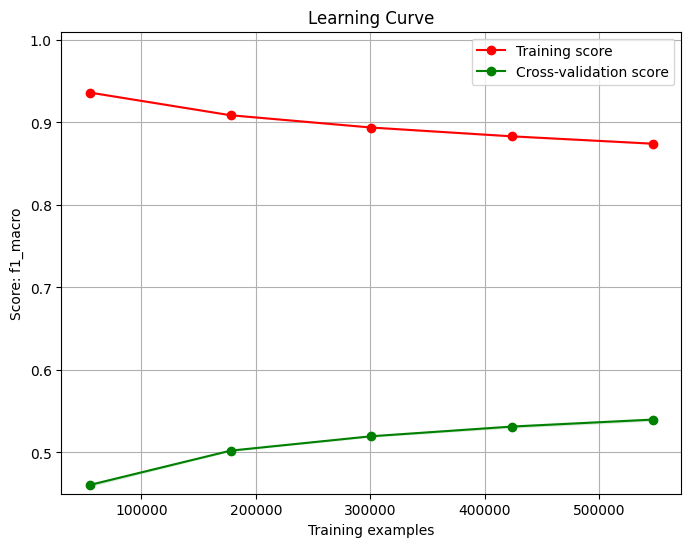

In [30]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_macro"
)
plt.show()

## Validação em conjunto de Teste

In [31]:
y_pred = classifier.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="macro")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 49.11%


### Preditos Positivos

In [32]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [33]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['fala quando quiser,se não quer tbm fds ppso 😡🤦🏻\u200d♀️',
       'eu só queria uma creatina boa e barata 😭', 'tentei ,eu jr 💔',
       'pena que é só em macapá 😔\U0001fae0',
       'essa vida de ficar c uma pessoa aqui outra ali ja enjoei 😡',
       'nicholas tem a pronúncia tão fofa 😭',
       'sabrina volta pra mim meu almoço não tem graça sem você 😭😭',
       'nossos sentimentos tá matando mais que a polícia 😔', 'bom diaa 😴',
       'preciso renovar minha marquinha 😖'], dtype=object)

#### Falso Positivo -> Neutro

In [34]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['melhor contando sobre o finde maravilhoso dela, enquanto eu só fiquei em casa 😥',
       'meu avô é muito engraçado cara 😂',
       'mês que vem sai os do fgts, partiu gastar essa grana absurda! 😂 que governo maravilhoso esse q me deixa tirar o…',
       'shit happens uai, eu te xingaria se fosse livre e espontânea vontade 😂',
       'e não é que o bexey melhorou o tipo de som dele 👀',
       'tu viu juiz de fora.😂 um forte abraço.',
       'lembra da mulher que engravidou de bebês? veja como eles estão anos depois. 😱',
       'estou assim 😂', 'amém que não 😂', 'praia show riqueza 👀👀👀'],
      dtype=object)

#### Verdadeiro Positivo

In [35]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['hj ninguém tira a minha paz 😁',
       'bom dia vida! muita energia positiva pra vc hj! já deu tudo certo 💜💜💜 torcendo mt por vc, sempre 🥰🥰🥰',
       'ㅤㅤ ㅤ 𝗜𝗡𝗦𝗧𝗔𝗚𝗥𝗔𝗠: storıes. ↳ @/logiedupont bom dia pexual 😖 ㅤ≡ ⌕ ⊞ ♡ ○',
       'a gente terminou de instalar a oi daí coloquei no telecine e tava passando o final de the greatest showman e agora tô chorando 👍',
       'não parece real de tão perfeita ❤',
       'o atrasa lado, sai p lá, tá querendo roubar o lugar dos aliados 🎶',
       'que bonito 😍', 'muito linda cr 😍', 'ofertas serias por mp 💌😏🙈🔥',
       'exatamente 😊'], dtype=object)

### Preditos Negativos

In [36]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [37]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['não tela , não é assim 😂😂',
       'nao tolero fã do mc kevin, se vc for um eu corto qualquer vínculo beijo💋',
       'você, querido! 😍',
       'faz um tempo que não tinha um dia dos pais tão de boas igual a esse 😌',
       'cm mano pauzão responsa mamadeirao ✌️🍆🍼🔥🔥🔥',
       'to triste querendo sumir e explodir vou comer bolo vai que me deixa feliz 👍',
       'eu tava indo dormir agora😭✊',
       'pensei que seria difícil ter alguém no governo tão irresponsável quanto bolsoverme. 🙈',
       'acordei cheia de calor, tomei um banho e agora tá me dando fome, aaai 😏',
       'a cara do lohan fazer isso 😂😂🤦🏻\u200d♀️'], dtype=object)

#### Falso Negativo -> Neutro

In [38]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['daqui a pouco tô com todos os moletons do guri na minha casa 😂🤡',
       'azias por coisas que eu decido na minha vida👀',
       'que fome do cão 😳',
       'não miga kkk já fui justificar meu erro 😂 não aparece nenhuma músicas deles na play…',
       's/o to 🔥', 'theodoro tá roncando 😳', 'mais alta que eu ainda 😅🥺',
       'não consigo dormir!!! 😢', 'kkk o twitter tava aberto na hora 😂',
       'tá tenso amg 😥'], dtype=object)

#### Verdadeiro Negativo

In [39]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['não tem como ir embora de barreiras sem ficar chateado! 😕',
       'cabelo cacheado dá tanto trabalho 😪',
       'que sdd de ir p madureira 😫',
       'ingratidão é um bglh muito foda!!👎', 'nada de bom dia 😔',
       'lunna foi ficar com o papai e eu já estou morrendo de sdd 😞',
       'sou muito cadelinha desses filhos da puta 😔',
       'cruzeiro ta igual eu so perde 😐',
       'ainda te perturbei ele esses dias no zap que isso jean😭',
       'vou dormir 😴'], dtype=object)

### Preditos Neutros

In [40]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [41]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['🤣😂🤣😂 bom dia, la mor!',
       'e no brilho de uma pedra falsa dei amor a quem não merecia. eu pensei que era uma jóia rara, era bijouteria 🎶',
       'farto de ver velhos a dançar tou eu, vais ali ao aviário é só 💃',
       'tenho pavor de sair na rua com berlim. mas hoje tive q trazer pra tomar banho. cada cachorro q vejo, pego ele no colo 😂😂',
       'fico feliz em ver as pessoas com os presente q eu dou 😍',
       'eu finjo q não sei pra continuar feliz, para de ficar lembrando autora😔✊🏼',
       'bêguman 🙏',
       'jorginho levando o atletico pro lugar onde ele se destaca... na série b !!😂😂😂',
       'caríssimos, ando a / gás, tal como os alemães, mas o meu não é russo 😆 (estou de férias)',
       'vivo na onda do lean mas nunca erro a mira 😎'], dtype=object)

#### Falso Neutro -> Negativo

In [42]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['não entra na minha cabeça essa porra de vogal e semivogal 😤',
       'olha o nível da pessoa,seria cōmico se não fosse trágico,😡',
       'mano mentira😨😨', 'nem me fale viu 😠',
       'sim, contra a juliette e contra camisa que não existe 😡😡😡',
       'errei em tantas coisas... q ódio 😔',
       'vontade gigante de volta pro rio logo, só falta meses 😞',
       'vou sentir sdds das minhas amigas de sala 😪', 'coitada 😨',
       'o pior é q eu sou hard, mas tô tendo surto de angry 😔'],
      dtype=object)

#### Verdadeiro Neutro

In [43]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['não curto mt ahah! agr deste me vontade de ir buscar nestum para mim 😂',
       'é essa kizomba do papi? 👀', 'não, meu pai gosta de sertanejo 😅',
       'se vocês pudessem montar o time dos laranjas para a bgc, qual seria a escalação? 🧡🔥',
       'nas redes socias eu escrevo tudo errado 😂',
       'a camisa branca está ficando um xuxu. 🥺 ela combina mais com o corpete. 😅',
       'kkk prefiro nem comentar 😂', 'eitaaa 😅',
       'do nosso lado (para variar😅), mas talvez tenhas razão, mesmo vestido de verde era capaz de dar a vantagem aos outros 🙈😐',
       'ma’am 😳'], dtype=object)